In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.preprocessing import scale

## Zbiór concrete

Będziemy używać podziału na zbiór treningowy i testowy (hold-out), stąd funkcja `train_test_split`

In [3]:
data = pd.read_csv("Datasets/concrete.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y)

## Wewnętrzna miara ważności zmiennych (algorytmy oparte o drzewa decyzyjne)

- oparte na impurity/RMSE, opisuje jak zmienna przyczynia się do wzrostu czystości/zmiejszenia błędu

wady: 
- może przykrwać podobną wysoce skorelowaną zmienną
- nie pokazuje kierunkowości ani jaki zakres zmiennej jest istotny
- pokazuje znaczenie zmiennej wyłącznie w zbiorze treningowym, może nie być to słuszne dla zbioru testowego
- ma znaczenie interpretacyjne tylko dla "dobrych modeli"

Zalety:
- łatwo dostępna, 
- intuicyjnie prosta do zrozumienia

In [4]:
estimator = RF().fit(X_train,y_train) # jak było trenowane drzewo
pd.DataFrame(estimator.feature_importances_,index=X.columns)

,0
cement,0.305854
slag,0.062929
flyash,0.019950
water,0.106296
superplasticizer,0.075697
coarseaggregate,0.028488
fineaggregate,0.041582
age,0.359204


## Ocena ważności zmiennej poprzez powtarzalne perturbacje wybranych zmiennych

- działa na podstawie losowego przemieszania wybranej zmiennej i sprawdzenia spadku wydajności estymatora
Zalety:
- analizuje rolę zmiennej w wytrenowanym modelu
- może być sprawdzana zarówno dla zbioru treningowego i testowego

In [5]:
trained = permutation_importance(estimator, X_train, y_train, n_repeats=30,random_state=0)
tested = permutation_importance(estimator, X_test, y_test, n_repeats=30,random_state=0)
pd.DataFrame(zip(trained['importances_mean'],tested['importances_mean']),index=X.columns,columns=["train","test"])

,train,test
cement,0.587222,0.647275
slag,0.131959,0.139431
flyash,0.014352,0.016054
water,0.148744,0.157222
superplasticizer,0.102300,0.103007
coarseaggregate,0.022882,0.011887
fineaggregate,0.047074,0.038207
age,0.801877,0.832033


Do oceny stablilności cech użyjemy odchylenia standardowego

Text(0.5, 1.0, 'Testing set')

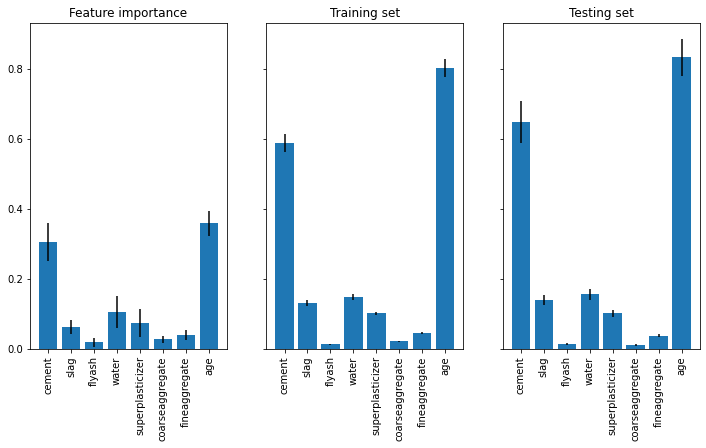

In [6]:
est_std = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0)

fig,axes = plt.subplots(ncols=3,figsize=(12,6),sharey=True)
axes[0].bar(X.columns,estimator.feature_importances_,yerr=est_std)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_title("Feature importance")

axes[1].bar(X.columns,trained.importances_mean,yerr=trained.importances_std)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_title("Training set")

axes[2].bar(X.columns,tested.importances_mean,yerr=tested.importances_std)
axes[2].tick_params(axis='x', labelrotation=90)
axes[2].set_title("Testing set")

## Ocena ważności zmiennych poprzez kombinacyjne usuwanie wybranych zmiennych

- działa podobnie jak metoda permutacyjnego usuwania zmiennych, z tą różnicą że za każdym razem trenowane są inne modele
- odpowiada czy można wytrenować dobry model bez danej zmiennej
- można stosować dla jednej lub dwóch zmiennych, dla większej liczby zmiennych może być problem z ekslozją kombinatoryczną

In [7]:
yhat =RF().fit(X,y).predict(X)
mae = mean_absolute_error(y,yhat)

inc_error = []
for v in X.columns:
    Xdash = X.drop(columns=v)
    model = RF().fit(Xdash,y)
    yhat = model.predict(Xdash)
    inc_error.append(mean_absolute_error(y,yhat)-mae)

pd.DataFrame(inc_error,X.columns)

,0
cement,0.215187
slag,0.069943
flyash,0.007603
water,0.077622
superplasticizer,0.030433
coarseaggregate,0.007203
fineaggregate,0.031860
age,6.312756


Dla dwóch zmiennych jest to zadanie trudniejsze, gdyż wymaga wyliczenia kombinacji zmiennych oraz są problemy z wizualizacją wyników. Wyniki kombinacyjnego usuwania dwóch zmiennych warto porównać z analizą korelacji pomiędzy zmiennymi.

In [8]:
from itertools import combinations
yhat =RF().fit(X,y).predict(X)
mae = mean_absolute_error(y,yhat)

inc_error = []
for v in combinations(X.columns,2):
    Xdash = X.drop(columns=list(v))
    model = RF().fit(Xdash,y)
    yhat = model.predict(Xdash)
    inc_error.append(mean_absolute_error(y,yhat)-mae)

In [9]:
m = np.zeros((len(X.columns),len(X.columns)))
m[np.triu_indices(len(X.columns),1)] = np.array(inc_error)
m = pd.DataFrame(m,columns=X.columns,index=X.columns)
m

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
cement,0.0,0.458846,0.381062,0.614065,0.265310,0.376471,0.617967,6.442920
slag,0.0,0.000000,0.167255,0.178920,0.124146,0.128563,0.286151,6.371129
flyash,0.0,0.000000,0.000000,0.099338,0.058931,0.022417,0.052480,6.325603
water,0.0,0.000000,0.000000,0.000000,0.179443,0.146495,0.103395,6.357913
superplasticizer,0.0,0.000000,0.000000,0.000000,0.000000,0.066896,0.032973,6.324920
coarseaggregate,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.089418,6.349234
fineaggregate,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.310250
age,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: >

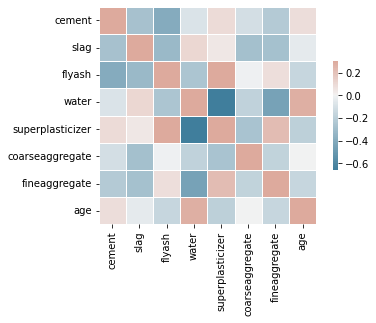

In [10]:
corr = X.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

# Redukcja wymiarowości

Redukcja wymiarowości opiera się na założeniu, że problem można przedstawić na podstawie znacznie mniejszej liczby wymiarów niż w rzeczywistości użyto. Nowe zmienne trzeba jednak jakoś zinterpretować. Istnieje wiele metod przeznaczoncyh do redukcji wymiarowości, przeanalizujemy 3: aglomerację cech (dendrogram); składowe główne (PC) oraz skalowanie wielowymiarowe. Te podejścia różnią się od strony technicznej (i wielu założeń teoretycznych) przede wszystkim w podejściu do interpretacji zmiennych. Metoda aglomeratywna reprezentuje grupowanie zmiennych na podstawie wybranych metryk i jest najprostrze do zrozumienia. PC opiera się na dekompozycji macierzy, a skalowanie wielowymarowe jest przykładem metod, próbujących zachować niepodobieństwo pomiędzy obiektami przy przejściu do przestrzeni o mniejszej liczbie wymiarów. Bardziej złożone metody niż MDS pozwalają na zastosowanie skalowania również w wyniku nieliniowych transformacji.

## Redukcja wymiarowości metodą dendrogramu (Feature Agglomeration)

Nie do końca jasny proces łączenia ze sobą (na zasadach uśredniania?) zmiennych wykazujących pewne podobieństwo. Pierwszym krokiem jest wizualizacja dendrogramu oraz ocena podobieństwa cech i możliwej redukcji wymiarowości poprzez połączenie podobnych zmiennych

In [25]:
from sklearn.cluster import FeatureAgglomeration
from scipy.cluster.hierarchy import dendrogram,linkage,set_link_color_palette
from scipy.spatial import distance as dst

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

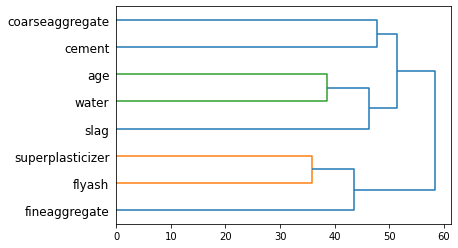

In [12]:
scaled = scale(X)
distance = dst.pdist(scaled.T,'euclidean')
d = dendrogram(linkage(distance,'complete'),labels=X.columns,orientation='right')

Po wyborze docelowej liczby zmiennych lub wartości progowej wykorzystujemy metodę klasę FeatureAgglomeration do połączenia zmiennych. Metoda nie jest opisana od strony technicznej. Nowe zmienne zachowują orginalne wartości jeżeli są jedyną zmienną w skupieniu lub tworzą nową zmienną na podstawie składowych.

In [13]:
agg = FeatureAgglomeration(n_clusters=5,distance_threshold=None,metric="euclidean",linkage='complete').fit(scaled)
trf = agg.transform(scaled)
yhat = RF().fit(trf,y).predict(trf)
print(np.sqrt(mean_absolute_error(y,yhat)))

rf = RF().fit(trf,y)
rf.feature_importances_

1.417356695626521


array([0.14531031, 0.25978593, 0.06914736, 0.37826323, 0.14749317])

**UWAGA:**
> Python nie ma funkcji pozwalającej na wyliczenie współczynnika wzajemnej korelacji dla dwóch zbiorów

In [14]:
def crosscor(raw,transformed):
    corr = np.corrcoef(raw,transformed, rowvar=False)
    cc = corr[raw.shape[1]:,:raw.shape[1]]
    return cc

Do oceny nowych zmiennych można wykorzystać macierz korelacji.

array([0.14531031, 0.25978593, 0.06914736, 0.37826323, 0.14749317])

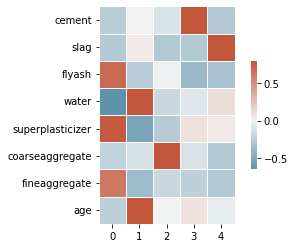

In [15]:
crs_cor = pd.DataFrame(crosscor(X,trf),columns=X.columns).T
sns.heatmap(crs_cor, cmap=cmap, vmax=.8, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
rf.feature_importances_

## Składowe główne (Principal Components `Analysis`)

Metoda pozwala na redukcję wymiarowości z określeniem wariancji wyjaśnianej przez poszczególne zmienne. Do znaczenia wyjaśniania nowych zmiennych służy macierz komponentów(components)

Porównajmy wydajność modelu opartego na dwóch najważniejszych zmiennych:

In [16]:
estimator = RF().fit(scaled,y)
yhat = estimator.predict(scaled)
print(np.sqrt(mean_absolute_error(y,yhat)))
print(pd.Series(estimator.feature_importances_,index=X.columns))

1.1013166115459414
cement              0.332566
slag                0.079224
flyash              0.015188
water               0.098585
superplasticizer    0.075467
coarseaggregate     0.029333
fineaggregate       0.037265
age                 0.332370
dtype: float64


In [17]:
Xdash = scaled[:,[0,7]]
yhat = RF().fit(Xdash,y).predict(Xdash)
print(np.sqrt(mean_absolute_error(y,yhat)))

1.8192041961727556


In [18]:
pca = PCA().fit(scaled)
trans = pca.transform(scaled)
regressor = RF().fit(trans, y)
print(regressor.feature_importances_)

[0.04096317 0.05067543 0.38518823 0.06407785 0.14533456 0.21939849
 0.05085644 0.04350584]


Najważniejsze składowe to 2 i 5. Wydajność regresora dla dwóch najważniejszych składowych jest wyższa niż dla dwóch zmiennych.

In [19]:
Xdash = trans[:,[2,5]]
yhat = RF().fit(Xdash,y).predict(Xdash)
print(np.sqrt(mean_absolute_error(y,yhat)))

1.7471812911573126


Do wizualizacji składowych głównych służy wykres biplot. Nie ma dobrej implementacji biplotu w Pythonie

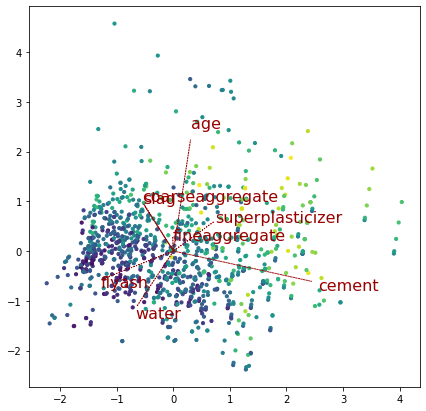

In [20]:
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(trans[:,2],trans[:,5],c=y,s=10) # pierwszy wykres: w przestrzeni składowych

scale = 3
loadings = pd.DataFrame(pca.components_,columns=X.columns)
coeffx = loadings.iloc[2]*scale
coeffy = loadings.iloc[5]*scale
for i in range(8): # drugi zmienne w przestrzeni składowych
    ax.arrow(0, 0, coeffx[i], coeffy[i],color = '#990000',alpha = 1,ls=":",lw=1)
    ax.text(coeffx[i]* 1.05, coeffy[i] * 1.15, loadings.columns[i], color = '#990000', ha = 'left', va = 'center',fontsize=16)


Alternatywą dla components jest uniwersalna metoda polegająca na obliczeniu współczynnika korelacji lub innej metryki. Różnice nie są wielkie.

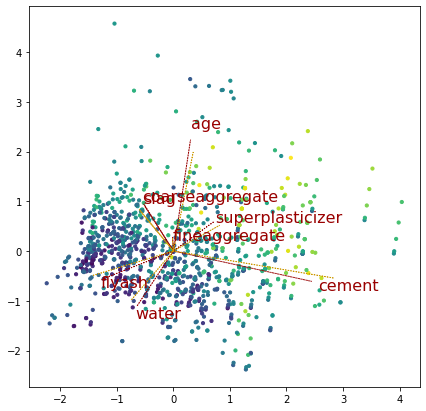

In [21]:
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(trans[:,2],trans[:,5],c=y,s=10) # pierwszy wykres: w przestrzeni składowych

scale = 3
loadings = pd.DataFrame(pca.components_,columns=X.columns)
coeffx = loadings.iloc[2]*scale
coeffy = loadings.iloc[5]*scale
for i in range(8): # drugi zmienne w przestrzeni składowych
    ax.arrow(0, 0, coeffx[i], coeffy[i],color = '#990000',alpha = 1,ls=":",lw=1)
    ax.text(coeffx[i]* 1.05, coeffy[i] * 1.15, loadings.columns[i], color = '#990000', ha = 'left', va = 'center',fontsize=16)

scale = 3
loadings = pd.DataFrame(crosscor(scaled,trans),columns=X.columns) # loadings zastąpione współczynnikiem korelacji
coeffx = loadings.iloc[2]*scale
coeffy = loadings.iloc[5]*scale
for i in range(8): # trzeci zmienne w przestrzeni składowych
    ax.arrow(0, 0, coeffx[i], coeffy[i],color = '#CC9900',alpha = 1,ls=":",lw=1)
    #ax.text(coeffx[i]* 1.05, coeffy[i] * 1.15, loadings.columns[i], color = '#CC9900', ha = 'left', va = 'center',fontsize=16)

## Transformacje wielorakie (manifold)

Uwzględniają nieliniowe zależności w danych. Opierają się na założeniu, że do przedstawienia złożoności danych wystarczy mniejsza liczba wymiarów. Przeanalizujemy transformację Stochastic Distribution Embedding z rozkładem t-Studenta. Jest to mniej znana forma transformacji. Dobrze odzwierciedla lokalną strukturę danych, szczególnie jeśli dane są zagnieżdzone w wielu rozgałęzieniach lub skupieniach

In [26]:
SNE = TSNE(n_components=2)
trans = SNE.fit_transform(X)
loadings = pd.DataFrame(crosscor(X,trans),columns=X.columns)

In [27]:
Xdash = trans[:,[0,1]]
yhat = RF().fit(Xdash,y).predict(Xdash)
print(np.sqrt(mean_absolute_error(y,yhat))) # błąd dużo mniejszy

1.5016893067482893


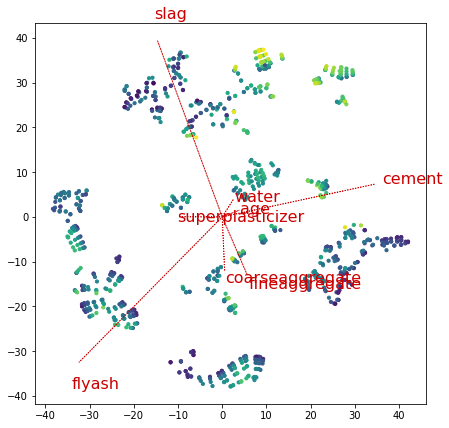

In [30]:
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(*trans.T,c=y,s=10) # pierwszy wykres: w przestrzeni składowych

scale = 50
loadings = pd.DataFrame(crosscor(scaled,trans),columns=X.columns) # loadings zastąpione współczynnikiem korelacji
coeffx = loadings.iloc[0]*scale
coeffy = loadings.iloc[1]*scale
for i in range(8): 
    ax.arrow(0, 0, coeffx[i], coeffy[i],color = '#CC0000',alpha = 1,ls=":",lw=1)
    ax.text(coeffx[i]* 1.05, coeffy[i] * 1.15, loadings.columns[i], color = '#CC0000', ha = 'left', va = 'center',fontsize=16)